In [14]:
%load_ext autoreload
%autoreload 2

In [7]:
from templates import *

In [2]:
device = 'cuda:0'
# conf = ffhq128_autoenc_72M()
conf = ffhq256_autoenc()
# print(conf.name)
model = LitModel(conf)
state = torch.load(f'checkpoints/{conf.name}/last.ckpt', map_location='cpu')
# state = torch.load(f'/home/coolboy/wwh/diffusion-autoencoders-main/output/latentweight/128_bs128_latent512/epoch_260_ckpt.pth', map_location='cpu')
# model.load_state_dict(state['model'], strict=False)
model.load_state_dict(state['state_dict'], strict=False)
model.ema_model.eval()
model.ema_model.to(device)
# fake_average_vector = torch.load('/home/coolboy/wwh/diffusion-autoencoders-main/256_StyleGAN_weight/latent_code/fake_mean_3w.pth')
# real_average_vector = torch.load('/home/coolboy/wwh/diffusion-autoencoders-main/256_StyleGAN_weight/latent_code/real_mean_3w.pth')

# fake_loaded_cond_list = torch.load('/home/coolboy/wwh/diffusion-autoencoders-main/weight/fake_conds180k.pth')
# real_loaded_cond_list = torch.load('/home/coolboy/wwh/diffusion-autoencoders-main/weight/real_conds180k.pth')

Global seed set to 0


Model params: 160.69 M


BeatGANsAutoencModel(
  (time_embed): TimeStyleSeperateEmbed(
    (time_embed): Sequential(
      (0): Linear(in_features=128, out_features=512, bias=True)
      (1): SiLU()
      (2): Linear(in_features=512, out_features=512, bias=True)
    )
    (style): Identity()
  )
  (input_blocks): ModuleList(
    (0): TimestepEmbedSequential(
      (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1): TimestepEmbedSequential(
      (0): ResBlock(
        (in_layers): Sequential(
          (0): GroupNorm32(32, 128, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (h_upd): Identity()
        (x_upd): Identity()
        (emb_layers): Sequential(
          (0): SiLU()
          (1): Linear(in_features=512, out_features=256, bias=True)
        )
        (cond_emb_layers): Sequential(
          (0): SiLU()
          (1): Linear(in_features=512, out_features=128, bias=True)

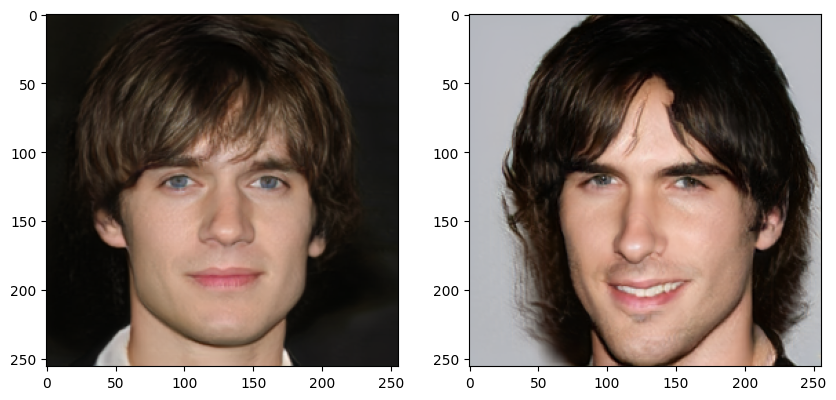

In [3]:
import matplotlib.pyplot as plt
from templates import *
data1 = ImageDataset('/home/coolboy/wwh/diffusion-autoencoders-main/temp', image_size=conf.img_size, exts=['jpg', 'JPG', 'png'], do_augment=False)
data2 = ImageDataset('/home/coolboy/wwh/diffusion-autoencoders-main/temp', image_size=conf.img_size, exts=['jpg', 'JPG', 'png'], do_augment=False)
batch1 = data1[1]['img'][None]
batch2 = data2[0]['img'][None]

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ori = (batch1 + 1) / 2
ax[0].imshow(batch1[0].permute([1, 2, 0]) / 2 + 0.5)
ax[1].imshow(batch2[0].permute([1, 2, 0]) / 2 + 0.5)

# 将数据转换到[0, 1]范围
# img_normalized = (batch1[0].numpy().transpose(1, 2, 0) + 1) / 2

# plt.imsave('batch3.png', img_normalized)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


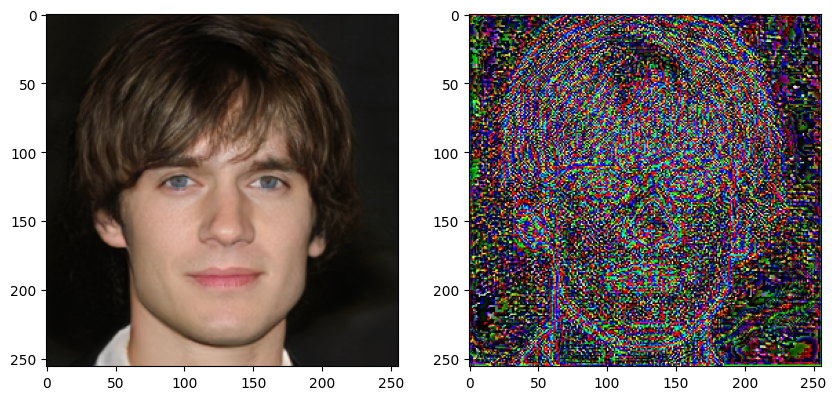

In [8]:
import matplotlib.pyplot as plt
import cv2
cond1 = model.encode(batch1.to(device))
# cond2 = model.encode(batch2.to(device))
device = torch.device("cuda:0")  # or whichever device you prefer

# fake_average_vector = fake_average_vector.to(device)
# real_average_vector = real_average_vector.to(device)
xT_1 = model.encode_stochastic(batch1.to(device), cond1, T=10).to(device)
# xT_2 = model.encode_stochastic(batch2.to(device), cond2, T=100).to(device)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ori = (batch1 + 1) / 2
ax[0].imshow(ori[0].permute(1, 2, 0).cpu())
ax[1].imshow(xT_1[0].permute(1, 2, 0).cpu())

# save_image(xT_1[0], f"/home/coolboy/wwh/diffusion-autoencoders-main/temp/pred1.png")

In [14]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from PIL import Image
import os

# Load the original image
original_img_path = '/home/coolboy/wwh/diffusion-autoencoders-main/temp/ref_15_img_9.png'
original_img = cv2.imread(original_img_path, cv2.IMREAD_COLOR)

# We will create a function that gradually adds noise to an image
def gradually_add_noise(img, steps=5):
    noisy_images = []

    # Compute the amount of noise to be added at each step
    increment = 255 // steps

    for i in range(steps):
        # Create noise to be added: we create a noise image that has the same size as the original image.
        # The noise is a random array with values between 0 and the current increment.
        noise = np.random.randint(0, increment * (i+1), img.shape, dtype='uint8')

        # Add the noise to the original image
        noisy_img = cv2.add(img, noise)

        # Save the noisy image to a temporary file and store its path
        temp_path = f'/home/coolboy/wwh/diffusion-autoencoders-main/temp/noisy_image_{i}.png'
        cv2.imwrite(temp_path, noisy_img)
        noisy_images.append(temp_path)
    
    return noisy_images

# Apply the function to the original image and save the sequence
noisy_images_paths = gradually_add_noise(original_img, steps=5)
noisy_images_paths


['/home/coolboy/wwh/diffusion-autoencoders-main/temp/noisy_image_0.png',
 '/home/coolboy/wwh/diffusion-autoencoders-main/temp/noisy_image_1.png',
 '/home/coolboy/wwh/diffusion-autoencoders-main/temp/noisy_image_2.png',
 '/home/coolboy/wwh/diffusion-autoencoders-main/temp/noisy_image_3.png',
 '/home/coolboy/wwh/diffusion-autoencoders-main/temp/noisy_image_4.png']

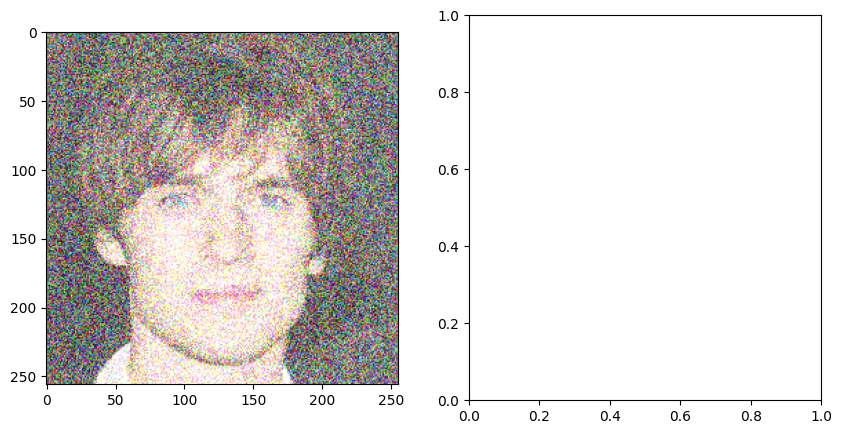

In [27]:
data1 = ImageDataset('/home/coolboy/wwh/diffusion-autoencoders-main/temp', image_size=conf.img_size, exts=['jpg', 'JPG', 'png'], do_augment=False)
original_img = data1[5]['img'][None]

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ori = (original_img + 1) / 2
ax[0].imshow(original_img[0].permute([1, 2, 0]) / 2 + 0.5)
# ax[1].imshow(batch2[0].permute([1, 2, 0]) / 2 + 0.5)

In [28]:
# Fake -> Real
from torchvision.utils import save_image

a = 1
b = 0
combine_vector = a * cond1 + b * cond2

# pred = model.render(xT_1, combine_vector, T=100)
# fig, ax = plt.subplots(1, 2, figsize=(10, 5))
# ori = (batch1 + 1) / 2
# ax[0].imshow(ori[0].permute(1, 2, 0).cpu())
# ax[1].imshow(pred[0].permute(1, 2, 0).cpu())
# # 保存整个plt输出
# fig.savefig("/home/coolboy/wwh/diffusion-autoencoders-main/imgs_render/Fake/complete_output_image.png")

# 仅保存pred图像
# save_image(pred[0], f"/home/coolboy/wwh/diffusion-autoencoders-main/imgs_render/Real/pred1.png")


pred = model.render(original_img, combine_vector, T=35)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ori = (batch1 + 1) / 2
ax[0].imshow(ori[0].permute(1, 2, 0).cpu())
ax[1].imshow(pred[0].permute(1, 2, 0).cpu())

RuntimeError: Input type (float) and bias type (c10::Half) should be the same

In [17]:
from detector.xception_net import Xception_Net
from torchvision import transforms, datasets
from efficientnet_pytorch import EfficientNet
import torch
device = 'cuda:0'
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225] 
data_transforms = {
    'test': transforms.Compose([
        transforms.Resize((256, 256)),
        # transforms.CenterCrop(256),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}
dir_path = '/home/coolboy/wwh/diffusion-autoencoders-main/imgs_render'
batch_size = 16
test_dataset = datasets.ImageFolder(dir_path, data_transforms['test'])
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size, shuffle=False, num_workers=0, pin_memory=True)
dataset_size = len(test_dataset)
print('size: {}'.format(dataset_size))
print('Class to index mapping:', test_dataset.class_to_idx)
classifier = Xception_Net()
# classifier = EfficientNet.from_name('efficientnet-b7').to(device)
# classifier = torchvision.models.resnet50(pretrained=False).to(device)
# num_ftrs = classifier.fc.in_features
# classifier.fc = nn.Linear(num_ftrs, 2)  # 将最后一层改为输出2类
# classifier = torchvision.models.mobilenet_v3_large(pretrained=False) # 或者mobilenet_v3_large
# classifier.classifier[3] = nn.Linear(classifier.classifier[3].in_features, 2)
# classifier = classifier.to(device)
weightpath = '/home/coolboy/wwh/diffusion-autoencoders-main/weight/Xception_model_best_1.0000_epoch1.pt'
# weightpath = '/home/coolboy/wwh/diffusion-autoencoders-main/weight/128_weight/effnet_model_best_1.0000_epoch4.pt'
# weightpath = '/home/coolboy/wwh/diffusion-autoencoders-main/weight/Resnet_model_best_1.0000_epoch4.pt'
# weightpath = '/home/coolboy/wwh/diffusion-autoencoders-main/weight/Mobile_model_best_1.0000_epoch1.pt'
check = torch.load(weightpath)
classifier.load_state_dict(check)
classifier = classifier.cuda()
classifier.eval()

for images, labels in test_loader:
   
    inputs = images.to(device)
    labels = labels.to(device)
    # print('labels', labels)
    with torch.no_grad():
        output = classifier(inputs)
        print('output', output)

    _, prediction = torch.max(output, 1)
    print('pred', prediction)

size: 3
Class to index mapping: {'Fake': 0, 'Real': 1}
output tensor([[ 1.1869, -1.4490],
        [-5.3958,  4.7815],
        [-5.3245,  4.7621]], device='cuda:0')
pred tensor([0, 1, 1], device='cuda:0')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


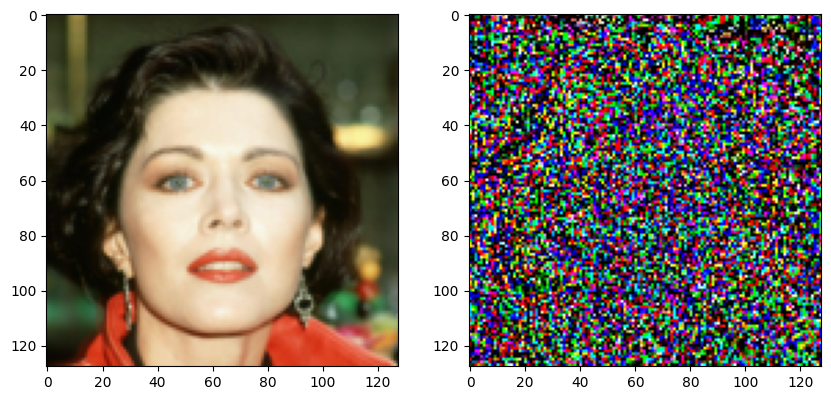

In [49]:
# real -> fake
import matplotlib.pyplot as plt
# cond1 = model.encode(batch1.to(device))
cond2 = model.encode(batch2.to(device))
device = torch.device("cuda:0")  # or whichever device you prefer
xT_2 = model.encode_stochastic(batch2.to(device), cond2, T=100)
xT_2 = xT_2.to(device)
fake_average_vector = fake_average_vector.to(device)
real_average_vector = real_average_vector.to(device)
# xT_2 = model.encode_stochastic(batch2.to(device), (cond1 + cond2) / 2, T=100)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ori = (batch2 + 1) / 2
ax[0].imshow(ori[0].permute(1, 2, 0).cpu())
ax[1].imshow(xT_2[0].permute(1, 2, 0).cpu())

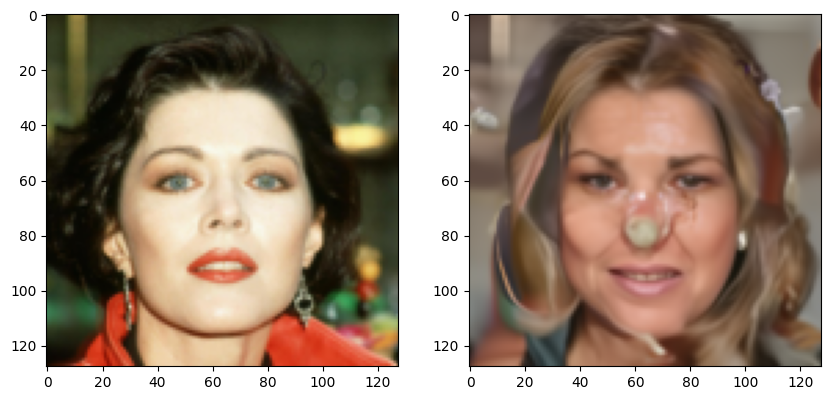

In [62]:
# Fake -> Real
from torchvision.utils import save_image

a = 0
b = 1
combine_vector = a * cond1 + b * fake_average_vector

pred = model.render(xT_2, combine_vector, T=100)
# pred = model.render(xT, cond1, T=100)
# pred = model.render(xT, cond2, T=100)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ori = (batch2 + 1) / 2
ax[0].imshow(ori[0].permute(1, 2, 0).cpu())
ax[1].imshow(pred[0].permute(1, 2, 0).cpu())
# # 保存整个plt输出
# fig.savefig("/home/coolboy/wwh/diffusion-autoencoders-main/imgs_render/Fake/complete_output_image.png")

# 仅保存pred图像
save_image(pred[0], f"/home/coolboy/wwh/diffusion-autoencoders-main/imgs_render/Real/pred1.png")

In [1]:
from detector.xception_net import Xception_Net
from torchvision import transforms, datasets
from efficientnet_pytorch import EfficientNet
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms, models
import torch
device = 'cuda:0'
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

data_transform = transforms.Compose([
    # transforms.Resize((256, 256)),
    transforms.CenterCrop(256),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

dir_path = '/home/coolboy/wwh/CelebA_raw_Data/val'
batch_size = 16
test_dataset = datasets.ImageFolder(dir_path, data_transforms['test'])
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size, shuffle=True, num_workers=0, pin_memory=True)
dataset_size = len(test_dataset)
print('size: {}'.format(dataset_size))
print('Class to index mapping:', test_dataset.class_to_idx)
# classifier = Xception_Net()
# classifier = EfficientNet.from_name('efficientnet-b7').to(device)
classifier = torchvision.models.resnet50(pretrained=False).to(device)
num_ftrs = classifier.fc.in_features
classifier.fc = nn.Linear(num_ftrs, 2)  # 将最后一层改为输出2类

# weightpath = '/home/coolboy/wwh/diffusion-autoencoders-main/weight/Xception_model_best_0.9996_epoch2.pt'
# weightpath = '/home/coolboy/wwh/diffusion-autoencoders-main/weight/128_weight/effnet_model_best_1.0000_epoch4.pt'
weightpath = '/home/coolboy/wwh/diffusion-autoencoders-main/weight/Resnet_model_best_1.0000_epoch1.pt'

check = torch.load(weightpath)
classifier.load_state_dict(check)
classifier = classifier.cuda()
classifier.eval()
correct, TP, TN, FP, FN = 0, 0, 0, 0, 0
total_tested = 0
total_correct = 0
interrupt = 0
for images, labels in test_loader:
    interrupt += 1
    if interrupt == 5:
        break
    inputs = images.to(device) 
    labels = labels.to(device)
    print('labels', labels)
    with torch.no_grad():
        output = classifier(inputs)

    _, prediction = torch.max(output, 1)
    total_tested += labels.size(0)
    total_correct += torch.sum(prediction == labels).item()
    print('pred', prediction)
    correct = torch.sum((prediction.detach()) == labels.detach().to(torch.float32))
    TP += torch.sum((prediction == 1) & (labels == 1))
    TN += torch.sum((prediction == 0) & (labels == 0))
    FP += torch.sum((prediction == 1) & (labels == 0))
    FN += torch.sum((prediction == 0) & (labels == 1))

    
    precision = TP.float() / (TP + FP).float()
    recall = TP.float() / (TP + FN).float()
    f1_score = 2 * (precision * recall) / (precision + recall)

    print('Testing {}:[{}/{} ({:.0f}%)] Acc: {}%'.format(interrupt, interrupt*batch_size, dataset_size,
                                                        100. * interrupt*batch_size / dataset_size,
                                                        correct / (batch_size) * 100))

print('True Positives: {}, True Negatives: {}, False Positives: {}, False Negatives: {}'.format(TP, TN, FP, FN))
# print('Precision: {:.4f}, Recall: {:.4f}, F1-score: {:.4f}， Acc: {:.4f}, ASR: {:.4f}'.format(precision, recall, f1_score, TN/1000 ,FP/1000))
print('Pre-Acc {:.4f}， After-Acc: {:.4f}, ASR: {:.4f}'.format(FN/10, TN/10 ,FP/10))
avg_accuracy = total_correct / total_tested
print('Average Accuracy: {:.2f}%'.format(avg_accuracy * 100))

NameError: name 'data_transforms' is not defined